# SimCLR Using Pytorch

**IMPORTANT NOTE: This implementation does not work** For a working implementation, check: [simclr_pytorch_flowers](https://github.com/mxagar/simclr_pytorch_flowers).

In [1]:
import os
import time
import random
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from tqdm import tqdm

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchvision.datasets import CIFAR10

## GPU Setup (Optional)

In [2]:
torch.__version__
# '1.13.0+cu117'

'1.13.0+cu117'

In [3]:
# Get info of all GPU devices
!nvidia-smi

Mon Jul 10 13:36:15 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:22:00.0 Off |                  N/A |
|  0%   42C    P8              14W / 170W |      0MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Set environment variable with possible device ids
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
print(os.environ["CUDA_VISIBLE_DEVICES"])
# Set device: 0 or 1
# NOTE: indices are not necessarily the ones shown by nvidia-smi
# We need to try them with the cell below
torch.cuda.set_device("cuda:0")

0,1


In [5]:
# Check that the selected device is the desired one
print("Torch version?", torch.__version__)
print("Torchvision version?", torchvision.__version__)
print("Is cuda available?", torch.cuda.is_available())
print("Is cuDNN version:", torch.backends.cudnn.version())
print("cuDNN enabled? ", torch.backends.cudnn.enabled)
print("Device count?", torch.cuda.device_count())
print("Current device?", torch.cuda.current_device())
print("Device name? ", torch.cuda.get_device_name(torch.cuda.current_device()))
x = torch.rand(5, 3)
print(x)

Torch version? 1.13.0+cu117
Torchvision version? 0.14.0+cu117
Is cuda available? True
Is cuDNN version: 8500
cuDNN enabled?  True
Device count? 1
Current device? 0
Device name?  NVIDIA GeForce RTX 3060
tensor([[0.1389, 0.8810, 0.3605],
        [0.8688, 0.2057, 0.9840],
        [0.6841, 0.2072, 0.1986],
        [0.8474, 0.6808, 0.5567],
        [0.6641, 0.3421, 0.3292]])


## Config and Dataset

In [6]:
class Config:
    def __init__(self):
        self.learning_rate = 0.001
        self.num_epochs = 100
        self.batch_size = 128
        self.patience = 10
        self.dropout_p = 0.3
        self.embedding_size = 64
        self.scheduler_step_size = 70
        self.scheduler_gamma = 0.1
        self.weight_decay = 1e-5 # 1.0889499856024069e-08
        # Other application variables
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.base_path = "./output"
        os.makedirs(self.base_path, exist_ok=True)  # Create the base_path directory if it doesn't exist
        self.best_model_path = os.path.join(self.base_path, "best_model.pth")
        self.last_model_path = os.path.join(self.base_path, "last_model.pth")
        self.learning_plot_path = os.path.join(self.base_path, "learning_curves.png")

In [7]:
# Dataset generator: Same image, two random augmentations
class PairDatasetAugmented(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]  # We don't need labels for SimCLR Training

        augmented_image_1 = image
        augmented_image_2 = image        
        if self.transform:
            augmented_image_1 = self.transform(image)
            augmented_image_2 = self.transform(image)

        return augmented_image_1, augmented_image_2

In [8]:
# Dataset generator: positive and negative pairs
class PairDatasetContrastive(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.pairs = self._make_pairs()

    def _make_pairs(self):
        # initialize an empty list to hold the image pairs and labels
        pairs = []

        # calculate the total number of classes present in the dataset
        # and then build a list of indexes for each class label that
        # provides the indexes for all examples with a given label
        # NOTE self.dataset.dataset accesses to the entire dataset
        # self.dataset.indices contains the indices of the Subset/current split
        #num_classes = len(np.unique(self.dataset.dataset.targets[self.dataset.indices]))
        num_classes = len(np.unique(self.dataset.dataset.targets)) # classes in ENTIRE dataset
        # Indices per class in SUBSET
        indices = [np.where(self.dataset.dataset.targets[self.dataset.indices] == i)[0] for i in range(num_classes)]
        # Negative indices per class in SUBSET: indices of images of different class
        neg_indices = [np.where(self.dataset.dataset.targets[self.dataset.indices] != i)[0] for i in range(num_classes)]

        # loop over all images
        for idx_a in range(len(self.dataset)):
            # grab the current image and label belonging to the current iteration
            _, label = self.dataset[idx_a]

            # randomly pick an image that belongs to the *same* class label
            idx_b = np.random.choice(indices[label])
            pos_image_idx = idx_b

            # prepare a positive pair and update the pairs list with the indices and label
            pairs.append((idx_a, pos_image_idx, 1))

            # grab the indices for each of the class labels *not* equal to the current label
            # and randomly pick an image corresponding to a label *not* equal to the current label
            #neg_indices = np.where(self.dataset.targets != label)[0]
            #neg_indices = np.where(self.dataset.dataset.targets != label)[0]
            #neg_image_idx = np.random.choice(neg_indices)
            neg_image_idx = np.random.choice(neg_indices[label])

            # prepare a negative pair of images and update the pairs list with the indices and label
            pairs.append((idx_a, neg_image_idx, 0))

        return pairs

    def __getitem__(self, index):
        img1_idx, img2_idx, label = self.pairs[index]
        img1, label1 = self.dataset[img1_idx]
        img2, label2 = self.dataset[img2_idx]
        assert (label1 == label2) == bool(label)
        return img1, img2, torch.tensor(int(label1 == label2), dtype=torch.float32)
    
    def __len__(self):
        return len(self.pairs)

## Model

In [11]:
class SiameseNetwork(nn.Module):
    def __init__(self, dropout_p=0.5, embedding_size=128):
        super(SiameseNetwork, self).__init__()
        self.backbone = models.resnet18(weights='ResNet18_Weights.DEFAULT')
        #self.backbone = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        self.embedding_size = embedding_size
        self.dropout_p = dropout_p

        # Remove the fully connected layer
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
                
        for param in self.backbone.parameters():
            param.requires_grad = True
        
        self.head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, embedding_size)
        )

        # Apply Xavier initialization
        nn.init.xavier_uniform_(self.head[0].weight)
        nn.init.xavier_uniform_(self.head[3].weight)
    
    def forward_one(self, x):
        x = self.backbone(x)
        x = x.view(x.size()[0], -1)
        x = self.head(x)
        
        return x
        
    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2
        
        return output1, output2

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5, device="cpu"):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.device = device

    def forward(self, z1, z2):
        # Normalize the representations along the batch dimension
        z1_norm = (z1 / z1.norm(dim=1)[:, None])
        z2_norm = (z2 / z2.norm(dim=1)[:, None])

        # Compute the cosine similarity matrix 
        # We add the temperature as a scaling factor (usually set to 0.5 or 0.1)
        representations = torch.cat([z1_norm, z2_norm], dim=0)
        similarity_matrix = torch.mm(representations, representations.t()) / self.temperature

        # Compute the loss
        batch_size = z1_norm.shape[0]
        contrastive_loss = torch.nn.functional.cross_entropy(
            similarity_matrix, torch.arange(2*batch_size).to(self.device)
        )
        
        return contrastive_loss

In [12]:
model = SiameseNetwork()
print(model)

SiameseNetwork(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [13]:
weights_sample = model.backbone[0].weight.detach().clone()
print("weights_sample (m, s): ", weights_sample.mean().item(), weights_sample.std().item())

weights_sample (m, s):  2.941965612990316e-05 0.1296982318162918


## Utils

In [14]:
# Prediction function
def predict_similarity(model, img1, img2, device="cpu"):
    model.eval()
    model.to(device)
    img1, img2 = img1.to(device), img2.to(device)
    
    with torch.no_grad():
        output1, output2 = model(img1, img2)
        
        # Normalize the output vectors
        output1 = F.normalize(output1, p=2, dim=1)
        output2 = F.normalize(output2, p=2, dim=1)
        
        # Compute the cosine similarities
        similarities = (output1 * output2).sum(dim=1).cpu().numpy()
        
    return similarities

In [15]:
# Plot training function
def plot_training(train_loss_history, val_loss_history, config):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(config.learning_plot_path)
    plt.show()

# Plot prediction function
def plot_prediction(img1, img2, similarities, limit=None):
    if limit is not None:
        img1, img2, similarities = img1[:limit], img2[:limit], similarities[:limit]

    fig, axs = plt.subplots(len(img1), 2, figsize=(5, 3*len(img1)))
    for i in range(len(img1)):
        img1_i = img1[i].permute(1, 2, 0) if img1[i].shape[0] == 3 else img1[i].squeeze()
        img2_i = img2[i].permute(1, 2, 0) if img2[i].shape[0] == 3 else img2[i].squeeze()

        cmap1 = None if img1[i].shape[0] == 3 else 'gray'
        cmap2 = None if img2[i].shape[0] == 3 else 'gray'

        axs[i, 0].imshow(img1_i.cpu(), cmap=cmap1)
        axs[i, 1].imshow(img2_i.cpu(), cmap=cmap2)
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')
        axs[i, 1].set_title(f"Similarity: {similarities[i]:.2f}")

    plt.tight_layout()
    plt.show()


In [16]:
# Save model function
def save_model(model, save_path):
    torch.save(model.state_dict(), save_path)

# Load model function
def load_model(model, load_path, device):
    model.load_state_dict(torch.load(load_path, map_location=device))
    return model

In [17]:
# CIFAR-10 mean and std values
def denormalize(image, mean=np.array([0.4914, 0.4822, 0.4465]), std=np.array([0.2023, 0.1994, 0.2010])):
    if image.dim() == 4:  # [batch_size, channels, height, width]
        img = image.permute(0, 2, 3, 1)  # Rearrange to [batch_size, height, width, channels]
        mean = torch.tensor(mean).view(1, 1, 1, 3)
        std = torch.tensor(std).view(1, 1, 1, 3)
    elif image.dim() == 3:  # [channels, height, width]
        img = image.permute(1, 2, 0)  # Rearrange to [height, width, channels]
        mean = torch.tensor(mean).view(1, 1, 3)
        std = torch.tensor(std).view(1, 1, 3)
    else:
        raise ValueError('Unsupported tensor shape.')

    img = img * std + mean  # De-normalize
    return img.clamp(0, 1)

## Training

In [28]:
# Training function
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, config, output_freq=2, debug=False):
    model.train()
    model = model.to(config.device)
    train_loss_history = []
    val_loss_history = []
    best_val_loss = float('inf')
    no_improve_epochs = 0
    total_batches = len(train_loader)
    print_every = total_batches // output_freq  # Print every 1/output_freq of total batches
    weights_before = None
    weights_after = None

    for epoch in range(config.num_epochs):
        start_time = time.time()
        train_loss = 0
        model.train()

        if debug:
            # Select the weights of a layer
            weights_before = model.backbone[0].weight.detach().clone()
        
        for i, (img1, img2) in enumerate(train_loader):
            img1, img2 = img1.to(config.device), img2.to(config.device)
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

            # Print training loss
            if i % print_every == 0:
                print(f"Epoch: {epoch+1}, Batch: {i+1}, Loss: {loss.item()}")

        scheduler.step()
        train_loss_history.append(train_loss / len(train_loader))

        #val_loss = validate(model, val_loader, criterion, config)
        val_loss = train_loss / len(train_loader)
        val_loss_history.append(val_loss)
        end_time = time.time()
        epoch_time = end_time - start_time

        if debug:
            weights_after = model.backbone[0].weight.detach().clone()
            print("[DEBUG] weights_before (m, s): ", weights_before.mean().item(), weights_before.std().item())
            print("[DEBUG] weights_after (m, s): ", weights_after.mean().item(), weights_after.std().item())
            print("[DEBUG] weights changed? ", not torch.equal(weights_before, weights_after))
        
        print(f"Epoch: {epoch+1}, Loss: {train_loss_history[-1]}, Val Loss: {val_loss}, Time: {epoch_time}s, Learning Rate: {scheduler.get_last_lr()[0]}")

        # Save last model
        save_model(model, config.last_model_path)    

        # Save best model & early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(model, config.best_model_path)
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= config.patience:
                print("Early stopping")
                break

    return train_loss_history, val_loss_history


# Validation function
def validate(model, val_loader, criterion, config):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, (img1, img2) in enumerate(val_loader):
            img1, img2 = img1.to(config.device), img2.to(config.device), labels.to(config.device)
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2)
            total_loss += loss.item()
    return total_loss / len(val_loader)

## Evaluate

In [29]:
# Evaluation
def evaluate_accuracy(model, test_loader, device='cpu'):
    model = model.to(device)
    model.eval()
    
    correct = 0
    total = 0

    with torch.no_grad():
        for (img1, img2) in tqdm(test_loader, desc="Evaluating", unit="batch"):
            img1, img2 = img1.to(device), img2.to(device)
            z1, z2 = model(img1, img2)
            z1_norm = (z1 / z1.norm(dim=1)[:, None])
            z2_norm = (z2 / z2.norm(dim=1)[:, None])

            representations = torch.cat([z1_norm, z2_norm], dim=0)
            similarity_matrix = torch.mm(representations, representations.t())

            batch_size = z1_norm.shape[0]
            labels = torch.arange(2*batch_size).to(device)

            predictions = torch.argmax(similarity_matrix, dim=1)
            correct += torch.sum(predictions[:batch_size] == labels[:batch_size]).item()
            total += batch_size

    accuracy = 100.0 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    
    return accuracy

In [30]:
def evaluate_class_similarity():
    pass

## Main Application

In [33]:
# Main function
def main(do_train=False):
    config = Config()

    # CIFAR10 Mean and Std Dev for normalization
    cifar10_mean = [0.4914, 0.4822, 0.4465]
    cifar10_std = [0.2023, 0.1994, 0.2010]

    # Define the transformations for the training set
    load_transform = transforms.Compose([
        transforms.Resize((230, 230)),
        transforms.ToTensor(),
        transforms.RandomCrop(224),
        transforms.Normalize(mean=cifar10_mean, std=cifar10_std)
    ])
        
    # Define transformations
    data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply([transforms.GaussianBlur(3,[.1, 2.])], p=0.5),
        #transforms.ToTensor(),
        #transforms.Normalize(mean=cifar10_mean, std=cifar10_std)
    ])

    # Load dataset
    cifar10_dataset = CIFAR10(root='./data', train=True, download=True, transform=load_transform)
    print("Dataset obtained!")

    # Split the dataset into train, validation, and test sets
    train_size = int(0.75 * len(cifar10_dataset))
    val_size = int(0.1 * len(cifar10_dataset))
    test_size = len(cifar10_dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(cifar10_dataset, [train_size, val_size, test_size])
    print("Dataset splits created!")

    # Create PairDataset* for each split
    train_dataset = PairDatasetAugmented(train_dataset, data_transforms)
    val_dataset = PairDatasetAugmented(val_dataset, data_transforms)
    test_dataset = PairDatasetAugmented(test_dataset, data_transforms)
    #test_dataset = PairDatasetAugmented(test_dataset)
    #test_dataset_contrastive = PairDataseContrastive(test_dataset)

    # Create DataLoader for each split
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=False, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, drop_last=True)
    print("Dataset loaders created!")

    # Instantiate the model, criterion, optimizer, and scheduler
    # We need to have a model also for the case in whic we don't train
    model = SiameseNetwork(embedding_size=config.embedding_size,
                           dropout_p=config.dropout_p).to(config.device)
    
    criterion = ContrastiveLoss(device=config.device)
    optimizer = Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    scheduler = StepLR(optimizer, step_size=config.scheduler_step_size, gamma=config.scheduler_gamma)

    # Test the model
    print("Predicting random batch...")
    test_img1, test_img2 = next(iter(test_loader))
    similarities = predict_similarity(model, test_img1, test_img2)
    # Plot predictions
    test_img1, test_img2 = denormalize(test_img1), denormalize(test_img2)
    plot_prediction(test_img1.to("cpu"), test_img2.to("cpu"), similarities, limit=3)
    
    # TRAIN!
    if do_train:
        train_loss_history, val_loss_history = train(model, train_loader, val_loader, criterion, optimizer, scheduler, config, output_freq=4, debug=True)

    # Load the best model
    model = SiameseNetwork(embedding_size=config.embedding_size,
                           dropout_p=config.dropout_p).to(config.device)
    model = load_model(model, config.best_model_path, config.device)

    # Evaluate
    print("Evaluating model...")
    evaluate_accuracy(model, test_loader)
    print("Evaluation completed!")
    
    # Test the model
    print("Predicting random batch...")
    test_img1, test_img2 = next(iter(test_loader))
    similarities = predict_similarity(model, test_img1, test_img2)
    # Plot predictions
    test_img1, test_img2 = denormalize(test_img1), denormalize(test_img2)
    plot_prediction(test_img1.to("cpu"), test_img2.to("cpu"), similarities, limit=10)

Files already downloaded and verified
Dataset obtained!
Dataset splits created!
Dataset loaders created!
Predicting random batch...


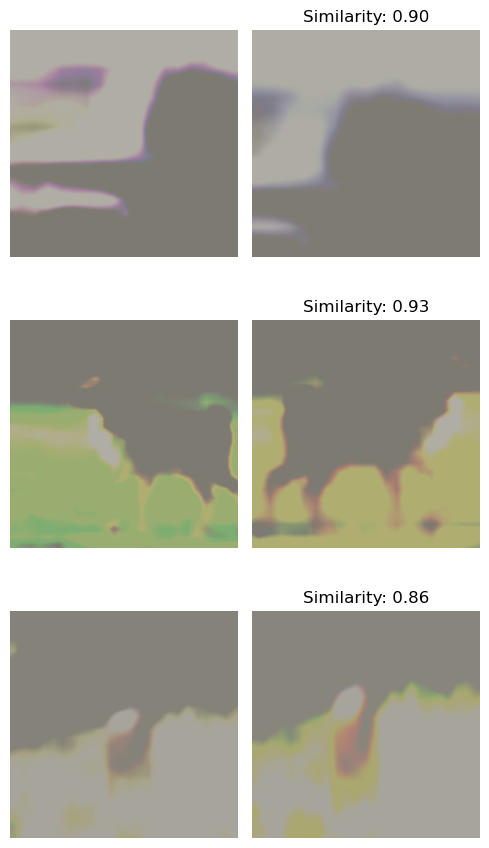

Epoch: 1, Batch: 1, Loss: 4.553882598876953
Epoch: 1, Batch: 74, Loss: 3.631829023361206
Epoch: 1, Batch: 147, Loss: 3.631115436553955
Epoch: 1, Batch: 220, Loss: 3.629383087158203
[DEBUG] weights_before (m, s):  2.941970706160646e-05 0.1296982318162918
[DEBUG] weights_after (m, s):  2.941970706160646e-05 0.1296982318162918
[DEBUG] weights changed?  False
Epoch: 1, Loss: 3.6408052215837454, Val Loss: 3.6408052215837454, Time: 951.789110660553s, Learning Rate: 0.001
Epoch: 2, Batch: 1, Loss: 3.6269752979278564
Epoch: 2, Batch: 74, Loss: 3.6251468658447266
Epoch: 2, Batch: 147, Loss: 3.6222853660583496
Epoch: 2, Batch: 220, Loss: 3.6222331523895264
[DEBUG] weights_before (m, s):  2.941970706160646e-05 0.1296982318162918
[DEBUG] weights_after (m, s):  2.941970706160646e-05 0.1296982318162918
[DEBUG] weights changed?  False
Epoch: 2, Loss: 3.62287369982837, Val Loss: 3.62287369982837, Time: 1100.4481327533722s, Learning Rate: 0.001
Epoch: 3, Batch: 1, Loss: 3.620577096939087
Epoch: 3, Batc

Evaluating: 100%|███████████████████████████████████████████████████████████████████| 58/58 [12:23<00:00, 12.82s/batch]


Accuracy: 99.81%
Evaluation completed!
Predicting random batch...


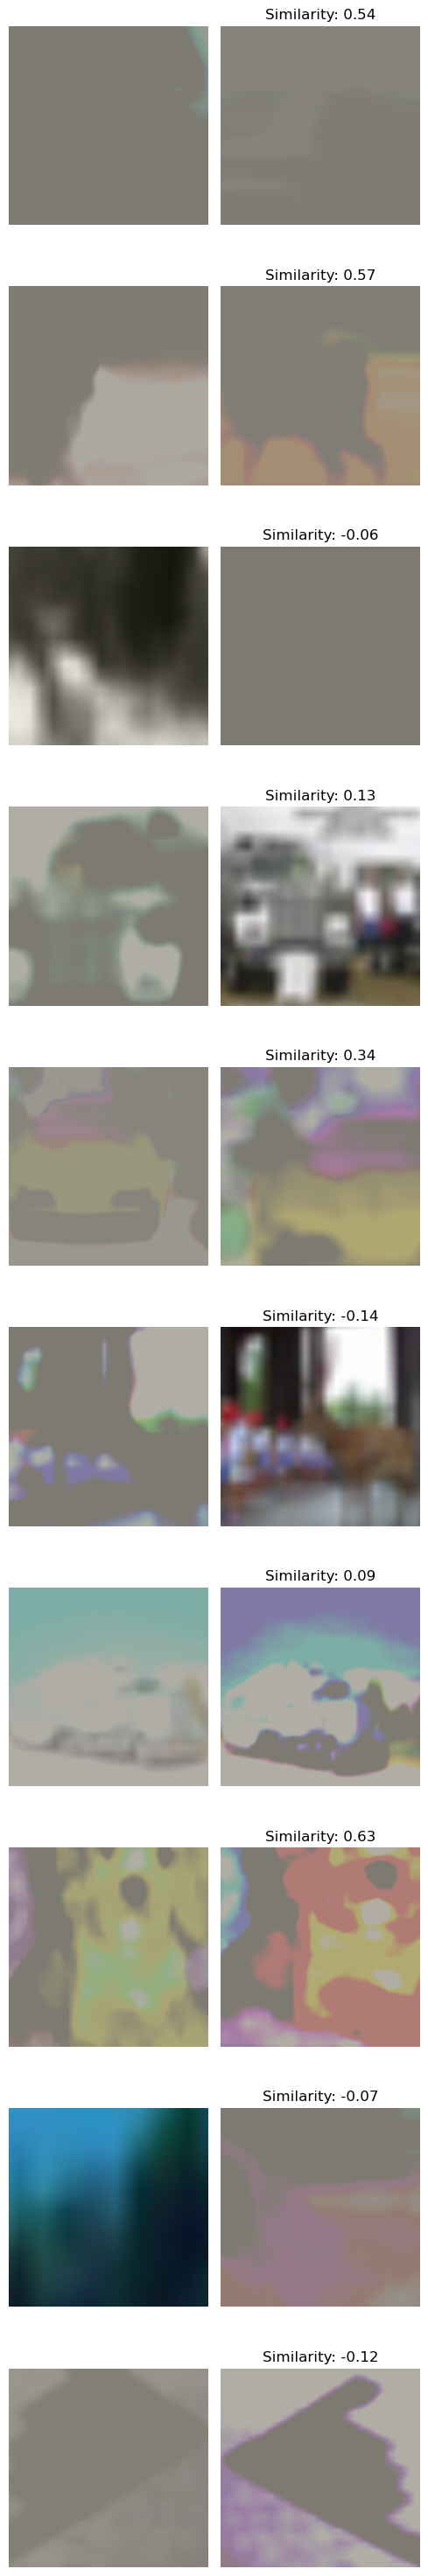

In [34]:
main(do_train=True)